# IHLT Lab 7: Word Sequences

**Author:** *Zachary Parent ([zachary.parent](mailto:zachary.parent@estudiantat.upc.edu))*

### 2024-10-31

**Instructions:**

1. Read all pairs of sentences of the SMTeuroparl files of test set within the evaluation framework of the project.

2. Compute their similarities by considering the following approach:
    * words plus NEs and Jaccard coefficient
    * ex: word_and_NEs=['John Smith', 'is', 'working']
    
3. Show the results.

4. Do you think it could be relevant to use NEs to compute the similarity between two sentences? Justify the answer.


## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from nltk.metrics.distance import jaccard_distance
import spacy

In [2]:


nlp = spacy.load("en_core_web_sm")


In [3]:
BASE_PATH = "./"

In [4]:
assert BASE_PATH is not None, "BASE_PATH is not set"

### Load the data

In [5]:
dt = pd.read_csv(
    f"{BASE_PATH}/test-gold/STS.input.SMTeuroparl.txt", sep="\t", header=None
)
dt.columns = ["s1", "s2"]
gs = pd.read_csv(f"{BASE_PATH}/test-gold/STS.gs.SMTeuroparl.txt", sep="\t", header=None)
dt["gs"] = gs[0]
dt.head()

,s1,s2,gs
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,4.50
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,5.00
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,4.25
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,4.50
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...",5.00


## Tools

### Previous NLP tools

In [6]:
def lemmatize_word(word):
    doc = nlp(word)
    return doc[0].lemma_

def lemmatize_tokens(tokens):
    return [token.lemma_ for token in tokens]

In [7]:
# Token pre-processing methods
def sentence_to_doc(sentence):
    return nlp(sentence)

def get_token_text(doc_or_tokens):
    return [token.text for token in doc_or_tokens]

def remove_non_alnum(words : list[str]):
    return [word for word in words if word.isalnum()]

def lower(words : list[str]):
    return [word.lower() for word in words]

def remove_stopwords(doc_or_tokens):
    return [token for token in doc_or_tokens if not token.is_stop]

### Scoring and pipeline methods

In [8]:
# Scoring methods
def jaccard_vector(s1, s2):
    return pd.concat([s1, s2], axis=1).apply(
        lambda x: jaccard_distance(set(x.iloc[0]), set(x.iloc[1])), axis=1
    )


def score_jaccard_vector(jaccard_vector, gold_standard=gs):
    return pearsonr(gold_standard[0], jaccard_vector)[0]

In [9]:
def apply_steps_to_sentence(sentence, steps):
    for i in range(len(steps)):
        sentence = steps[i](sentence)
        yield sentence

def apply_steps_and_score(s1_values, s2_values, steps):
    for i in range(len(steps)):
        s1_values = s1_values.apply(steps[i])
        s2_values = s2_values.apply(steps[i])
        if s1_values[0].__class__ != list or s1_values[0][0].__class__ != str:
            s1_tokens = s1_values.apply(get_token_text)
            s2_tokens = s2_values.apply(get_token_text)
        else:
            s1_tokens = s1_values
            s2_tokens = s2_values

        yield score_jaccard_vector(jaccard_vector(s1_tokens, s2_tokens))


### Named Entity (NE) chunking

This is the key new step.

In [10]:
def chunk_NEs(doc):
    with doc.retokenize() as retokenizer:
        tokens = [token for token in doc]
        for ent in doc.ents:
            retokenizer.merge(doc[ent.start:ent.end], 
                attrs={"LEMMA": " ".join([tokens[i].text 
                                    for i in range(ent.start, ent.end)])})
    return [token for token in doc]

## Previous Results

In [11]:
steps = [
    sentence_to_doc,
    remove_stopwords,
    lemmatize_tokens,
    lower,
    remove_non_alnum
]

previous_results = pd.DataFrame(
    { 'score':
        apply_steps_and_score(dt["s1"], dt["s2"], steps), 
        's1[0]': apply_steps_to_sentence(dt["s1"].iloc[0], steps),
        's2[0]': apply_steps_to_sentence(dt["s2"].iloc[0], steps),
    }, 
    index=[step.__name__ for step in steps]
)
previous_results

,score,s1[0],s2[0]
sentence_to_doc,-0.460603,"(The, leaders, have, now, been, given, a, new,...","(The, leaders, benefit, aujourd, ', hui, of, a..."
remove_stopwords,-0.468166,"[leaders, given, new, chance, let, hope, seize...","[leaders, benefit, aujourd, ', hui, new, luck,..."
lemmatize_tokens,-0.489411,"[leader, give, new, chance, let, hope, seize, .]","[leader, benefit, aujourd, ', hui, new, luck, ..."
lower,-0.495948,"[leader, give, new, chance, let, hope, seize, .]","[leader, benefit, aujourd, ', hui, new, luck, ..."
remove_non_alnum,-0.539914,"[leader, give, new, chance, let, hope, seize]","[leader, benefit, aujourd, hui, new, luck, let..."


## Results including Named Entity chunking

In [12]:
steps = [
    sentence_to_doc,
    chunk_NEs,
    remove_stopwords,
    lemmatize_tokens,
    lower,
    remove_non_alnum
]
results = pd.DataFrame(
    { 'score':
        apply_steps_and_score(dt["s1"], dt["s2"], steps), 
        's1[0]': apply_steps_to_sentence(dt["s1"].iloc[0], steps),
        's2[0]': apply_steps_to_sentence(dt["s2"].iloc[0], steps),
    }, 
    index=[step.__name__ for step in steps]
)
results

,score,s1[0],s2[0]
sentence_to_doc,-0.460603,"(The, leaders, have, now, been, given, a, new,...","(The, leaders, benefit, aujourd, ', hui, of, a..."
chunk_NEs,-0.422249,"[The, leaders, have, now, been, given, a, new,...","[The, leaders, benefit, aujourd, ', hui, of, a..."
remove_stopwords,-0.430508,"[leaders, given, new, chance, let, hope, seize...","[leaders, benefit, aujourd, ', hui, new, luck,..."
lemmatize_tokens,-0.442828,"[leader, give, new, chance, let, hope, seize, .]","[leader, benefit, aujourd, ', hui, new, luck, ..."
lower,-0.448624,"[leader, give, new, chance, let, hope, seize, .]","[leader, benefit, aujourd, ', hui, new, luck, ..."
remove_non_alnum,-0.446523,"[leader, give, new, chance, let, hope, seize]","[leader, benefit, aujourd, hui, new, luck, let..."


## Analysis

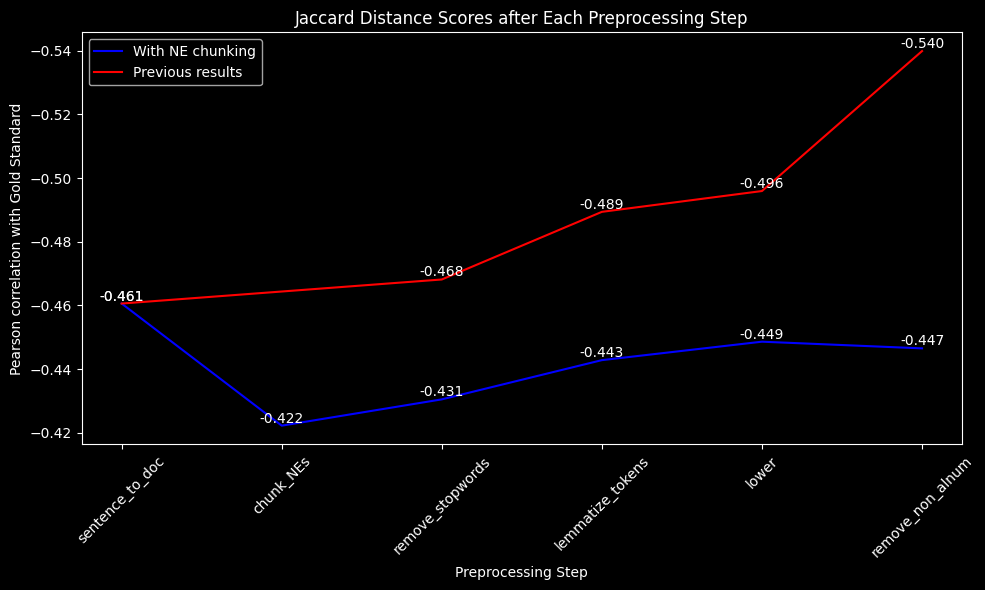

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(results['score'], color="blue", label="With NE chunking")
plt.plot(previous_results['score'], color="red", label="Previous results")
plt.title("Jaccard Distance Scores after Each Preprocessing Step")
plt.xlabel("Preprocessing Step")
plt.ylabel("Pearson correlation with Gold Standard")
plt.xticks(rotation=45)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.tight_layout()
plt.legend()
# Annotate chart values
for i, v in enumerate(results["score"].values):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom", color="white")
for i, v in enumerate(previous_results["score"].values):
    plt.text(i + 1 if i > 0 else i, v, f"{v:.3f}", ha="center", va="bottom", color="white")
plt.show()

As we can see above, the previous pipeline remains the best performing one. Adding NE chunking with spacy decreases the performance.

### Leave one out Analysis

In [14]:
steps = [
    sentence_to_doc,
    chunk_NEs,
    remove_stopwords,
    lemmatize_tokens,
    lower,
    remove_non_alnum
]

steps_to_skip = [
    chunk_NEs,
    remove_stopwords,
    lower,
    remove_non_alnum,
]

leave_one_out_results = pd.DataFrame(columns=["score"])

for step_to_skip in steps_to_skip:
    steps_to_use = [step for step in steps if step != step_to_skip]
    print(f"Skipping {step_to_skip.__name__}")
    scores = list(apply_steps_and_score(dt["s1"], dt["s2"], steps_to_use))
    leave_one_out_results.loc[step_to_skip.__name__] = scores[-1]
leave_one_out_results.loc["full_pipeline"] = results.loc[:,"score"].iloc[-1]

leave_one_out_results = leave_one_out_results
print("Leave one out results:")
leave_one_out_results

Skipping chunk_NEs
Skipping remove_stopwords
Skipping lower
Skipping remove_non_alnum
Leave one out results:


,score
chunk_NEs,-0.539914
remove_stopwords,-0.406310
lower,-0.443864
remove_non_alnum,-0.448624
full_pipeline,-0.446523


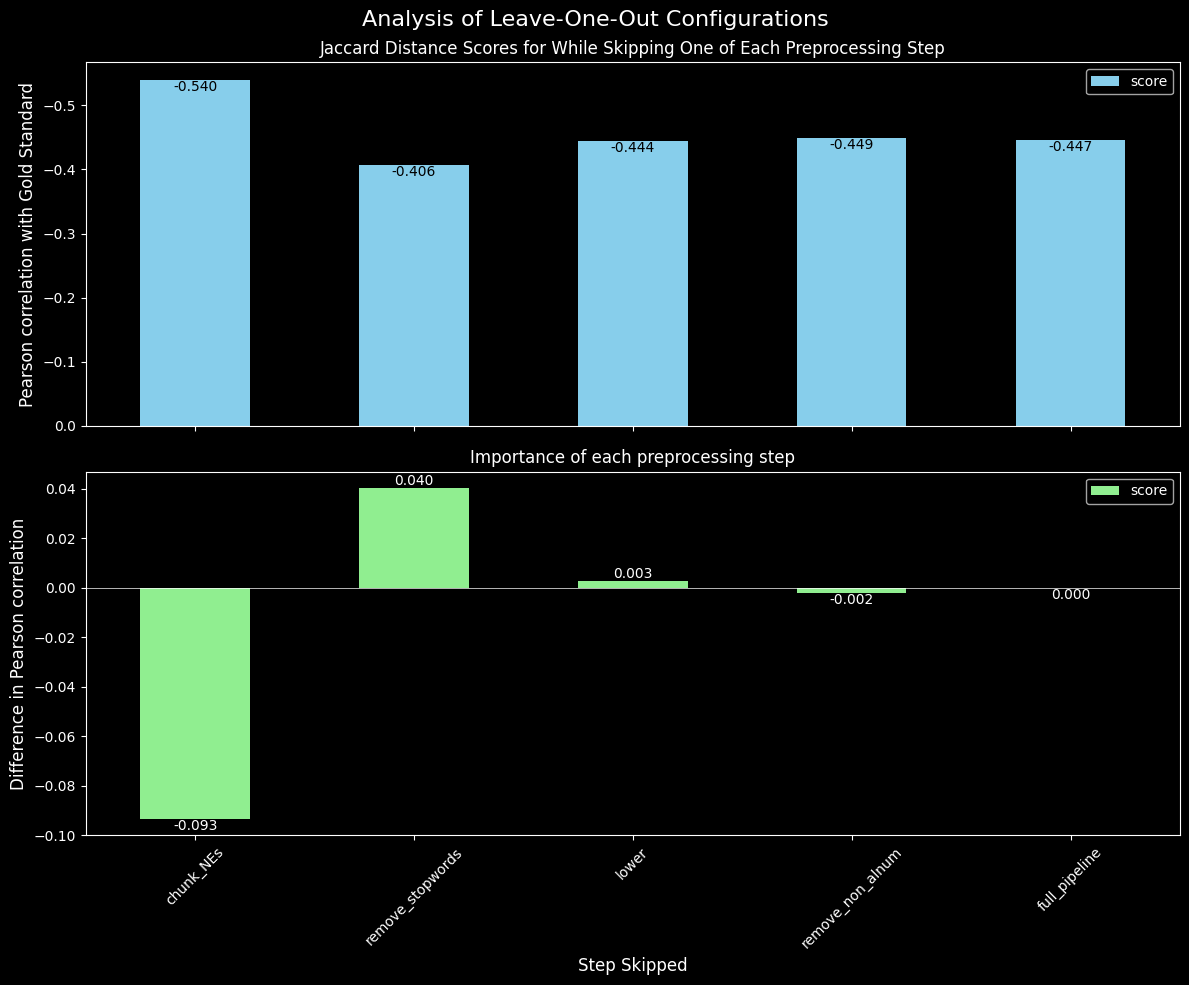

In [15]:
# Plot bar chart for leave-one-out results and differences from full pipeline
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

fig.suptitle("Analysis of Leave-One-Out Configurations", fontsize=16)

# Original bar chart
leave_one_out_results.plot(kind="bar", color=["skyblue"], ax=ax1)
ax1.set_title(
    "Jaccard Distance Scores for While Skipping One of Each Preprocessing Step"
)
ax1.set_ylabel("Pearson correlation with Gold Standard", fontsize=12)
ax1.invert_yaxis()

# Annotate original bar chart values
for i, v in enumerate(leave_one_out_results["score"].values):
    ax1.text(i, v, f"{v:.3f}", ha="center", va="top", color="black")

# Calculate and plot differences from full pipeline
full_pipeline_score = leave_one_out_results.T["full_pipeline"].values[0]
differences = leave_one_out_results.subtract(full_pipeline_score)
differences.plot(kind="bar", color=["lightgreen"], ax=ax2)
ax2.set_title("Importance of each preprocessing step")
ax2.set_xlabel("Step Skipped", fontsize=12)
ax2.set_ylabel("Difference in Pearson correlation", fontsize=12)
ax2.tick_params(axis="x", rotation=45)

# Annotate difference bar chart values
ax2.axhline(0, color="white", linewidth=0.5)
for i, v in enumerate(differences.values):
    ax2.text(
        i,
        v,
        f"{v[0]:.3f}",
        ha="center",
        va="bottom" if v[0] > 0 else "top",
        color="white",
    )

plt.tight_layout()
plt.show()

Above, we compare the full pipeline, including Named Entity (NE) chunking, with the results of skipping each preprocessing step. We can see that skipping stopword removal is the most detrimental, and skipping NE chunking is the least detrimental. In fact, skipping NE chunking improves the results.

# Analysis & Conclusions




### Key Results

In this lab we have continued our work of trying to improve the performance of our similarity analysis between sentences. We have explored the use of Named Entity (NE) chunking to improve the performance of our metric.

As previously found, a pipeline consisting of removing stopwords, lemmatizing, lowercasing and removing non-alphanumeric tokens leads to the best results, with a Pearson correlation with the Gold Standard of `-0.540`. Adding an NE-chunking step with Spacy decreased the performance of the full pipeline to `-0.447`.

### Leave-one-out analysis

We employed the use of leave-one-out analysis to understand the importance of each preprocessing step. We discovered that NE-chunking does not improve the performance of our metric, and in fact, skipping it improves the results. This is most likely because NE-chunking causes important information in the sentence, like the key subjects, to be grouped, making them have less importance in the Jaccard Distance.

Our best performing pipeline is still `remove_stopwords`, `lemmatize`, `lower` and `remove non_al_num`, yielding a pearson correlation of `-0.540` with the Gold Standard.

### Future work

Perhaps in the future we could explore a strategy in which words which get chunked also end up being duplicated or tripled (multiplied by n for n words that become chunked) in order to maintain the importance in the Jaccard Distance when there's a match, but allowing NE-chunking to disambiguate Named Entities that don't match.

e.g. "Mark Pederson" in a sentence should count as 2 matches to "Mark Pederson" and 0 matches to "Mark Twain".

**NOTE:** We have continued to use Jaccard Distance correlation as opposed to Jaccard Similarity, as that is how we performed the analysis in previous labs. While this leads to negative correlations, it allows us to compare the results from last lab and this lab consistently.